In the previous section, we learned all about plotting with matplotlib using the `pyplot` interface. And, in the last two lessons of this section, we took a deeper look at the architecture of matplotlib and the components that make up a typical plot. In this lesson, we'll go even deeper, and put what we've learned to the test by tracing the steps that the `pyplot` interface goes through "behind the scenes". 

Now, before we can get started, we have a little bit of setup that we need to do to make everything as clear as possible, so let's go ahead and jump right in and get started.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Setup

One of the differences between this lesson and those of the previous section, is that in this lesson, we want to be in complete control over when our plots are rendered. So, our first step will be to turn off interactive mode.

In [2]:
# Turn off interactive mode, so we have full control
# over when our plots are displayed.
plt.ioff()

Next, rather than displaying our plots inline, in this lesson, for reasons we'll cover later, we'll be saving each figure to a file instead. To do so, we'll need a directory in which to save our plots, and the bash code below creates that directory for us. 

One thing I'd like to point out here is that the directory that we're creating resides within the `/tmp` directory. So, if you happen to be following along on a Windows machine, or if you just don't have the right permissions to modify the `/tmp` directory, you'll want to change the `tmpdir` variable on line 3 below before running the code in the next cell.

In [3]:
%%bash --out tmpdir

tmpdir="/tmp/mpl"
if [ -d "$tmpdir" ]
then 
    rm -rf "$tmpdir"
fi
mkdir "$tmpdir"

echo -n "$tmpdir"

## Helper Functions

In the next few cells we'll be creating a few helper functions that we'll use throughout the rest of this lesson. Now, if you don't have a ton of experience with python, you may be looking at the code below and thinking to yourself "What do you mean functions? All I see are a handful of classes!" Well, you're right, at least partially. 

### Callable Objects

You'll notice in each of the classes below we've implemented this weird looking method (`__call__`) with leading and trailing underscores. This type of method is what pythonistas call a magic method, and they're usually pronounced "dunder <method_name>", so in our case, the method in question is called "dunder call". Implementing this method, allows instances of a class to be called just like a function. The really nice thing about this feature is that these callable objects have state that can change, as well as change the behavior of the function, with every call. This is nice because it allows us to setup some variables that are used, and altered, by the function without making those variables global.

For example, the first class below, `FilenameGenerator`, takes two variables when it's created: a base directory, which will be the temp directory we created in the last step, and a filename extension. It will then use these two variables, along with a third, to generate a filename every time it's called. 

Now, in order to save each consecutive figure without overwriting the previous one, the filenames that our function generates should be unique. In addition, we also want to display the figures we saved in the order in which we saved them, so we'll need the filenames to be sortable as well. To solve both requirements, we have a third variable, called `fignum`, that contains an integer value that's incremented with every call to our function. To create a unique and sortable filename, we simply append its value to the end.

If we were to try and do this without a callable object, we would either need to create the `fignum` variable as a global variable, or use a closure to prevent the variable from leaking into the global space. The first approach, using a global variable, is just bad practice for so many reasons, and with respect to the second option, I personally feel that callable objects are a little easier to understand than closures, and a bit cleaner as well. 

In [4]:
class FilenameGenerator(object):
    """A generator for creating unique filenames.
    """
    def __init__(self, basedir, ext):
        self.basedir = basedir
        self.ext = ext
        self.fignum = 0
    def __call__(self):
        self.fignum += 1
        return '%s/fig_%02d.%s' % (self.basedir, self.fignum, self.ext)
generate_filename = FilenameGenerator(tmpdir, 'png')

The next helper function, or more accurately, callable object, is a simple print function that takes a message and prints it with a leading line number. To do this, we'll need a variable that we can increment every time our function is called. On line 3 below, you can see that we've created and initialized that variable, and on line 6, you can see where we're incrementing it every time our function is called. We've also added a simple `reset` function on lines 7 and 8 that we can use to start the numbering over whenever we want. 

In [5]:
class PrintlnFunc(object):
    def __init__(self):
        self.line = 1
    def __call__(self, msg):
        print "%2d. %s" % (self.line, msg)
        self.line += 1
    def reset(self):
        self.line = 1
println = PrintlnFunc()

Finally, the next callable object is a decorator that adds some simple logging to a function. When called, it will print out a bit of information on the function it's decorating before and after calling that function. We'll use this callable object to decorate several functions in the matplotlib library so we can trace the set of function calls that are made every time we call a function from the `pyplot` interface. Now, the reason we're using a callable object here instead of a simple function, is because we need a variable to keep track of the depth of the call stack, so we can make our logging information a little more readable by indenting the logging info according to the current call stack depth.

In [6]:
class Logger(object):
    """Wraps a function in a callable that prints call information
    """
    level = 0

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, *args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        padding = "|" + "-" * (Logger.level * 4 - 1) if Logger.level > 0 else ""
        Logger.level += 1

        # Print calling information, call the function, and print returning info
        println("%sCalling %s.%s" % (padding, self.fn.__module__, self.fn.__name__))
        result = self.fn(*args, **kwargs)
        println("%sReturning <%s:%s> from %s.%s" % \
            (padding, result.__class__.__name__, id(result), self.fn.__module__, self.fn.__name__))

        # Decrease the call stack level, since we are returning.
        Logger.level -= 1
        return result

## Exploring the `pyplot` Call Stack

So, now that we have a bunch of helper functions setup and ready to be used, we're ready to start exploring how `pyplot` works. First, we'll use the `Logger` class that we created in the last cell to decorate several functions on the `pyplot` module.

In [7]:
# Decorate several methods with the logger
plt.gca = Logger(plt.gca)
plt.gcf = Logger(plt.gcf)
plt.figure = Logger(plt.figure)
plt.close = Logger(plt.close)

We also want to decorate a few methods on the `Figure` and `Axes` classes, especially the `__init__` functions so we can see when a new instance of class each is being created, but decorating a function attached to a class is a bit different from decorating a normal function. To make this possible, we'll have to use the `types.MethodType` class to wrap our `Logger` object. Other than that, the code below is pretty much identical to the last bit.

In [8]:
# To decorate the methods on the Figure class, we have to wrap 
# our logger in a MethodType instance.
import types

# Logging the calls for which the pyplot functions are simple
# proxies. Specifically, the add_subplot and __init__ methods
# are interesting because the allow us to see when new objects
# are being created.
from matplotlib.figure import Figure
from matplotlib.axes import Axes
Figure.gca = types.MethodType(Logger(Figure.gca), None, Figure)
Figure.add_subplot = types.MethodType(Logger(Figure.add_subplot), None, Figure)
Figure.__init__ = types.MethodType(Logger(Figure.__init__), None, Figure)
Axes.__init__ = types.MethodType(Logger(Axes.__init__), None, Axes)

So, now we have everything set up to make it possible to trace all the work that the `pyplot` interface is doing on our behalf whenever we call a simple plotting function. The only thing left to do is to actually plot something.

In [9]:
plt.hist(np.random.randn(1000));

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |-------Calling matplotlib.pyplot.figure
 4. |-----------Calling matplotlib.figure.__init__
 5. |-----------Returning <NoneType:4296543296> from matplotlib.figure.__init__
 6. |-------Returning <Figure:4368671376> from matplotlib.pyplot.figure
 7. |---Returning <Figure:4368671376> from matplotlib.pyplot.gcf
 8. |---Calling matplotlib.figure.gca
 9. |-------Calling matplotlib.figure.add_subplot
10. |-----------Calling matplotlib.axes._base.__init__
11. |-----------Returning <NoneType:4296543296> from matplotlib.axes._base.__init__
12. |-------Returning <AxesSubplot:4397144208> from matplotlib.figure.add_subplot
13. |---Returning <AxesSubplot:4397144208> from matplotlib.figure.gca
14. Returning <AxesSubplot:4397144208> from matplotlib.pyplot.gca


What we see happening above, and detailed in the diagram below, is that the `pyplot.hist()` function first tries to get the current `Axes` object by calling the `pyplot.gca()` function. If you remember, in the last lesson, I mentioned that the `Axes` class was the main interface for plotting, so it makes sense for the `hist` function to first grab the current axes. To get the current axes, the `pyplot.gca()` function must first get the current `Figure`, and it does so by calling the `pyplot.gcf()` function---remember, the `Figure` object is the root object that contains all other components in a plot, including the `Axes` objects. To get the current `Figure`, the `pyplot.gcf()` function will check for the top most figure on a stack of figures, and if one exists, it will return it. Otherwise, it will call the `pyplot.figure()` function to create a new `Figure`, and add it to the top of the stack, before returning it to the calling function. After getting the current figure, the `pyplot.gca()` function will check if that figure contains an `Axes` object, and if it doesn't, it will call the `add_subplot()` function on the `Figure` instance to create a new one. Finally, after the `pyplot.gca()` function returns the current axes object, the `pyplot.hist()` function will call the `Axes.hist()` function on the `Axes` object to create our histogram.

![pyplot Stateful Interface](../images/pyplot_stateful_interface.jpeg "pyplot Stateful Interface")

Now, we're not going to show the histogram that we've created just yet, because the interactive backends (i.e., the UI and Jupyter notebook backends) automatically destroy the figure object once it's shown. Since we want to see how the `pyplot` interface works both with, and without, a current figure, we'll save our histogram to disk instead to keep the current figure object on the stack. 

The call below will save the current figure to the temp directory we created at the begining of this lesson using the `generate_filename()` callable object we made to create a unique and sortable filename.

<!--- the _pylab_helpers.destroy function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. However, when rendering a hardcopy the figure is not destroyed, and so calling any plot command will simply add to the current figure. There are two ways to prevent this from happening: first, you can call the plt.clf() function to clear the current figure before you reuse it, second, you can call the plt.figure() function to create a new figure. We'll go with first option here and save the call to plt.figure() for our next lesson --->

In [10]:
plt.savefig(generate_filename())

15. Calling matplotlib.pyplot.gcf
16. Returning <Figure:4368671376> from matplotlib.pyplot.gcf


You probably noticed that calling the `pyplot.savefig()` function caused the `pyplot.gcf()` function to be called. By having a stateful interface that keeps track of the current figure being used, the `pyplot` module has saved us a few keystokes by allowing us to save a figure without explicitly stating which figure to save. 

If you want to see the figure stack itself, you can simply call the `pyplot.get_fignums()` to get a list of the figures in the stack.

In [11]:
plt.get_fignums()

[1]

## Where's the State

The `pyplot.get_fignums()` function that we called above is one way to peer into the underlying state of the `pyplot` module, but it's still a layer of abstraction on top of the real thing. If you really want to see the stack itself, you can find it inside of the `_pylab_helpers` module. In this module, you'll find a singleton class, called `Gcf`, that contains a list of `Figure` objects called the `Gcf._activeQue`. This unfortunatley named class variable is the stack of figures that the `pyplot` module uses to manage the current state of the system. To see what's in the stack, we'll create a function, that we'll call `print_fig_stack`, that will loop through each figure and print its figure number and `id`.

In [12]:
from matplotlib import _pylab_helpers

def print_fig_stack():
    for figmgr in _pylab_helpers.Gcf._activeQue:
        print "(%d, <Figure:%d>)" % (figmgr.num, id(figmgr.canvas.figure))

And, if we run our new function, we'll get a view of the actual figure stack.

In [13]:
print_fig_stack()

(1, <Figure:4368671376>)


Again, we can conclude two things after using this function: first, we have exactly one figure in the current stack, and second, that figure is the same one that we created with our very first call to the `pyplot.hist()` function (you can tell by looking at the `id`'s).

Using our `print_fig_stack` function, we can see that we have a current figure that we can now reuse, but of course there's one problem with reusing a figure: calling anymore plot commands will simply add to the current figure, which isn't what we want at all. Now, to prevent this from happening, you'll need to wipe the contents from the current figure, and you can do so with a call to the `pyplot.clf()` function, which is short for "clear figure".

In [14]:
plt.clf()

17. Calling matplotlib.pyplot.gcf
18. Returning <Figure:4368671376> from matplotlib.pyplot.gcf


Now we can create another plot and see how the `pyplot` interface acts when we already have an existing `Figure` object. But first, before we do that, we want to start the line numbering over. So, let's call the `println.reset()` function that we added to our `println` callable earlier. 

In [15]:
println.reset()

Then, we call the `pyplot.plot()` function to plot a line graph connecting a bunch of random points.

In [16]:
plt.plot(np.random.randn(100))

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |---Returning <Figure:4368671376> from matplotlib.pyplot.gcf
 4. |---Calling matplotlib.figure.gca
 5. |-------Calling matplotlib.figure.add_subplot
 6. |-----------Calling matplotlib.axes._base.__init__
 7. |-----------Returning <NoneType:4296543296> from matplotlib.axes._base.__init__
 8. |-------Returning <AxesSubplot:4397808656> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4397808656> from matplotlib.figure.gca
10. Returning <AxesSubplot:4397808656> from matplotlib.pyplot.gca


This time around, you'll notice that there are slightly fewer calls. Again, the `pyplot.gca()` and `pyplot.gcf()` functions are called, but there's already a figure present on the stack, so the `pyplot.figure()` function is never called to create a new `Figure` object. Outside of that, everything looks nearly identical to the `pyplot.hist()` call above. 

Let's go ahead and save our new figure once again using our `generate_filename()` function to save the new figure to the temp directory with the next consecutive filename.

In [17]:
plt.savefig(generate_filename())

11. Calling matplotlib.pyplot.gcf
12. Returning <Figure:4368671376> from matplotlib.pyplot.gcf


Since we saved the figure again, instead of showing it, its `id` should match that of the figure in the call to `pyplot.hist()` above, and we can prove that by once again calling our `print_fig_stack()` function.

In [18]:
print_fig_stack()

(1, <Figure:4368671376>)


Yep, that `id` matches the one from the earlier call above.

Now, just to prove that everything else worked as you'd expect, we're going to display each of the images we saved for the figures we created earlier. The code below, loops through each of the image files in the temp directory we created at the start of this lesson, and displays each one using the `display_png` function that IPython provides.

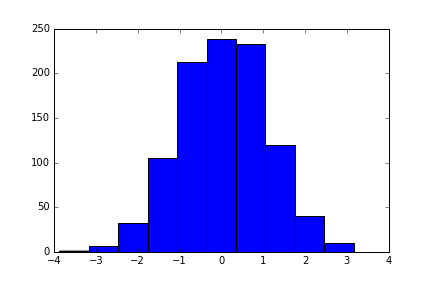

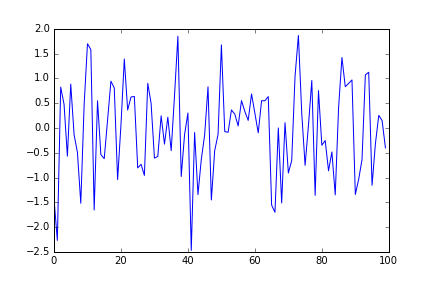

In [19]:
import glob
from IPython.display import Image, display_png
images = sorted(glob.glob('%s/*.png' % tmpdir))
for img_fname in images:
    display_png(Image(filename=img_fname))

## Conclusion

And, that's going to bring us to the end. 

In this lesson, we took what we've learned over the past two and got an x-ray view of the inner workings of the `pyplot` interface. We saw how the interface abstracts away the creation of `Figure` and `Axes` objects, and we also saw the class where the internal state of the system is kept. Overall, you should have a much better idea of how matplotlib works, and you should be able to reason more effectively when using the `pyplot` interface. But, we're not done just yet! 

In the next lesson, we'll dive into the `pyplot` interface one last time to learn about how it manages the stack of figures so we can avoid some common memory problems when working with the interface.